In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import seaborn as sb
mpl.rcParams["figure.figsize"] = (15,8)
import numpy as np
import matplotlib.pyplot as plt
import stingray.simulator as ss
from stingray.lightcurve import Lightcurve
from stingray.events import EventList
from tqdm import tqdm
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


In [2]:
BUFFER_LC = Lightcurve([0, 1], [1, 1], gti=[[-0.5, 1.5]], dt=1, err_dist='gauss')
def pulsar_events(length, period, ctrate, pulsed_fraction=0.5, bkg_ctrate=0):
    dt = period / 20
    times = np.arange(dt/2, length + dt/2, dt)
    cont_lc = ctrate * (1 + pulsed_fraction * np.cos(2 * np.pi / period * times)) * dt
    lc = BUFFER_LC
    lc.time = times
    lc.counts = cont_lc
    lc.gti = [[0, length]]
    lc.dt = dt
#     Lightcurve(times, cont_lc, err_dist='gauss', dt=dt)
    events = EventList()
    events.simulate_times(lc)
    return events



/Users/sean/anaconda/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [3]:
ctrate = 0.1
bkg_ctrate = 0
period = 1

pulsed_fraction = 0.5
events = pulsar_events(100, 1., ctrate)

In [4]:
lc = Lightcurve.make_lightcurve(events.time, 0.1)

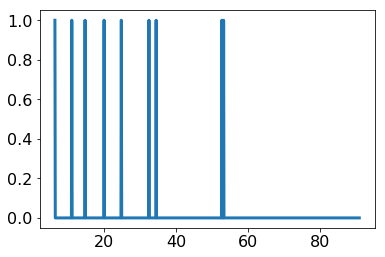

0.01060070671378092


In [5]:
lc.plot()
print(np.mean(lc.counts))

In [6]:
from stingray.pulse.pulsar import z2_n_detection_level, z_n, fold_events
from astropy.table import Table

def detected_pulse_fraction(pf_min, pf_max, length_min, length_max, 
                            ctrate_min=1.4, ctrate_max=1.4, 
                            period_min=1, period_max=1, n_realizations=1000, 
                            ntrial=1000, results=None, nbin=128):
    if results is None:
        results = Table(names=["period", "countrate", "pf", 
                               "length", "detected"], 
                        dtype=[float, float, float, float, bool])

    detlev = z2_n_detection_level(ntrial=ntrial)

    pfs = 10**np.random.uniform(np.log10(pf_min), 
                                np.log10(pf_max), n_realizations)
    lengths = 10**np.random.uniform(np.log10(length_min), 
                                    np.log10(length_max), n_realizations)
    periods = 10**np.random.uniform(np.log10(period_min), 
                                    np.log10(period_max), n_realizations)
    ctrates = 10**np.random.uniform(np.log10(ctrate_min), 
                                    np.log10(ctrate_max), n_realizations)

#     print('All variables generated')
    for i in tqdm(range(n_realizations)):
        pf, length, period, ctrate = pfs[i], lengths[i], periods[i], ctrates[i]
        events = pulsar_events(length, period, ctrate, pulsed_fraction=pf)
        phase = np.arange(0, 1, 1 / nbin)
        zsq = z_n(phase, n=2,
                  norm=fold_events(events.time, 1/period, nbin=nbin)[1])
        detected = False
        if zsq > detlev:
            detected = True
        results.add_row([period, ctrate, pf, length, detected])

    return results
        

In [7]:
pfmin, pfmax = 0.1, 0.5
lengthmin, lengthmax = 1000, 200000
ctrate_min, ctrate_max = 0.1, 0.1
period_min, period_max = 1, 1
table = detected_pulse_fraction(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=10000, ntrial=10000)

/Users/sean/anaconda/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Z2_n: The treatment of ntrial is very rough. Use with caution
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
100%|██████████| 10000/10000 [02:30<00:00, 66.37it/s]


# First attempt: linear SVM, log10 of features

In [8]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [9]:
idx = np.arange(len(table), dtype=int)
indices_train = np.random.randint(0, len(table), len(table)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table)) if k not in indices_train])
full_dataset = np.array(table["pf", "length"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [10]:
linear_clf.fit(np.log10(features_train), labels_train)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
linear_clf.score(np.log10(features), labels)

0.9419866444073456

In [12]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, len_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [13]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} L = 0$".format(const, pf_fact, len_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} L = {:.2f}$".format(pf_fact / len_fact, -const / len_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / len_fact) + "}" + " L = {:.2f}$".format(10**(-const / len_fact))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

which is not too dissimilar from the expected $LF^2$ relationship

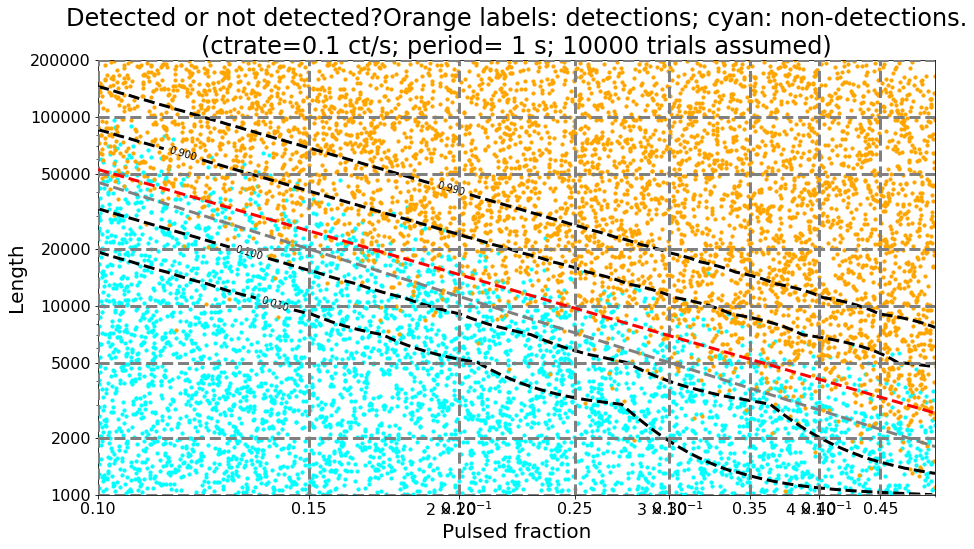

In [14]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(lengthmin, lengthmax, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table["detected"] == True
bad = np.logical_not(good)
plt.scatter(table["pf"][bad], table["length"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table["pf"][good], table["length"][good], color="orange", 
            label="Detected", s=10)
plt.title("Detected or not detected?"
          "Orange labels: detections; cyan: non-detections.\n"
          "(ctrate={} ct/s; period= {} s; 10000 trials assumed)".format(ctrate, period))
plt.xlabel("Pulsed fraction")
plt.ylabel("Length")
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([lengthmin, lengthmax])
# plt.xticks([0.1, 0.2, 0.3])
# plt.yticks([200, 500, 1000, 2000])
ax = plt.gca()
xticks = np.arange(pfmin, pfmax, 0.05)
yticks = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels(['{:.2f}'.format(x) for x in xticks])
ax.set_yticklabels(['{:d}'.format(y) for y in yticks])
for x in xticks:
    plt.axvline(x, color='grey', ls='--', zorder=10)
for y in yticks:
    plt.axhline(y, color='grey', ls='--', zorder=10)
# plt.ticklabel_format(style='plain')
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)
plt.savefig('detection.jpg')

## Counts vs PF, fixed length

In [33]:
pfmin, pfmax = 0.01, 0.4
lengthmin, lengthmax = 7e5, 7e5
ctrate_min, ctrate_max = 0.001, 0.1
period_min, period_max = 1, 1


# %prun -D pf_profile.prof detected_pulse_fraction(pfmin, pfmax, lengthmin, lengthmax, ctrate_min, ctrate_max, period_min, period_max, n_realizations=1)

In [34]:
# !snakeviz pf_profile.prof

In [35]:
table = detected_pulse_fraction(pfmin, pfmax, lengthmin, lengthmax, 
                                ctrate_min, ctrate_max, period_min, period_max,
                                n_realizations=1000, ntrial=1000)

100%|██████████| 1000/1000 [08:19<00:00,  2.00it/s]


In [36]:
from sklearn.svm import SVC
linear_clf = SVC(kernel="linear",  C=1, probability=True)

In [37]:
idx = np.arange(len(table), dtype=int)
indices_train = np.random.randint(0, len(table), len(table)//3)
indices_train = np.unique(indices_train)

indices = np.asarray([k for k in range(len(table)) if k not in indices_train])
full_dataset = np.array(table["pf", "countrate"])
dataset = np.take(full_dataset, indices)

labels = np.array(np.take(table["detected"], indices))

training_dataset = np.take(full_dataset, indices_train)
labels_train = np.array(np.take(table["detected"], indices_train))

features = np.zeros((len(dataset), len(list(dataset[0]))))
for i in range(len(dataset)):
    features[i, :] = list(dataset[i])

features_train = np.zeros((len(training_dataset), len(list(training_dataset[0]))))
for i in range(len(training_dataset)):
    features_train[i, :] = list(training_dataset[i])

In [38]:
linear_clf.fit(np.log10(features_train), labels_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
linear_clf.score(np.log10(features), labels)

0.93548387096774188

In [40]:
linear_clf.coef_, linear_clf.intercept_
const, pf_fact, ctr_fact = linear_clf.intercept_[0], linear_clf.coef_[0][0], linear_clf.coef_[0][1]

In [41]:
from IPython.display import display, Math, Latex
display(Math(r"${:.2f} + {:.2f} \log_{{10}} F + {:.2f} \log_{{10}} C = 0$".format(const, pf_fact, ctr_fact)))
display(Math(r"${:.2f} \log_{{10}} F + \log_{{10}} C = {:.2f}$".format(pf_fact / ctr_fact, -const / ctr_fact)))

display(Math(r"$F^{" + "{:.2f}".format(pf_fact / ctr_fact) + "}" + " C = {:.2f}$".format(10**(-const / ctr_fact))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<a list of 4 text.Text objects>

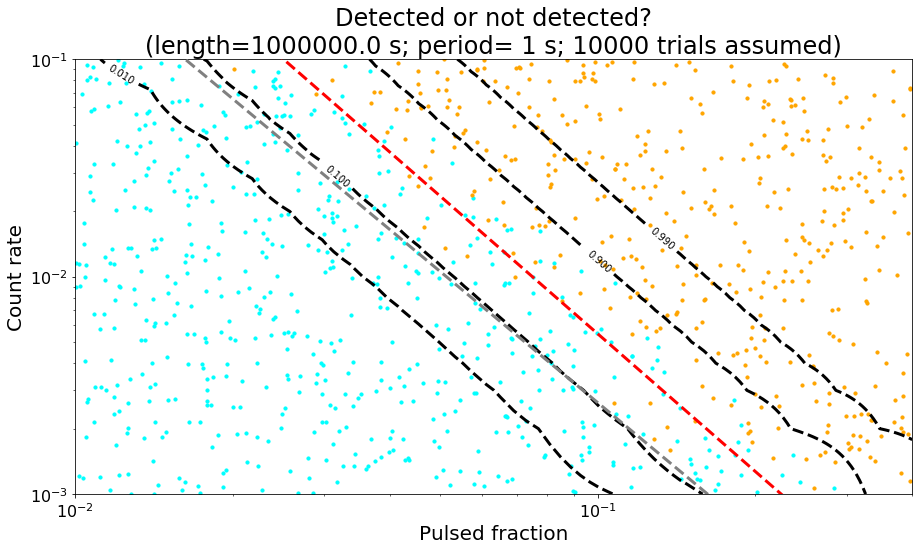

In [42]:
xs = np.linspace(pfmin, pfmax, 100)
ys = np.linspace(ctrate_min, ctrate_max, 100)
xx, yy = np.meshgrid(xs, ys)
Xfull = np.c_[xx.ravel(), yy.ravel()]

proba = linear_clf.predict_proba(np.log10(Xfull))

proba_detection = proba[:,1].reshape((100, 100))

plt.figure(figsize=(15, 8))
# plt.pcolormesh(xx, yy, proba_detection, cmap='Greys_r')
# plt.colorbar()

good = table["detected"] == True
bad = np.logical_not(good)
plt.scatter(table["pf"][bad], table["countrate"][bad], color="cyan", 
            label="Not detected", s=10)
plt.scatter(table["pf"][good], table["countrate"][good], color="orange", 
            label="Detected", s=10)
plt.title("Detected or not detected?\n"
          "(length={} s; period= {} s; 10000 trials assumed)".format(1e6, 1))
plt.xlabel("Pulsed fraction")
plt.ylabel("Count rate")
plt.loglog()
plt.xlim([pfmin, pfmax])
plt.ylim([ctrate_min, ctrate_max])
# plt.xticks([0.1, 0.2, 0.3])
# plt.yticks([200, 500, 1000, 2000])
ax = plt.gca()
# xticks = np.arange(pfmin, pfmax, 0.05)
# yticks = [200, 500, 1000, 2000, 5000, 10000, 20000]
# ax.set_xticks(xticks)
# ax.set_yticks(yticks)
# ax.set_xticklabels(['{:.2f}'.format(x) for x in xticks])
# ax.set_yticklabels(['{:d}'.format(y) for y in yticks])
# for x in xticks:
#     plt.axvline(x, color='grey', ls='--', zorder=10)
# for y in yticks:
#     plt.axhline(y, color='grey', ls='--', zorder=10)
# plt.ticklabel_format(style='plain')
C_exp = -linear_clf.intercept_/linear_clf.coef_[0, 1]
F_exp = linear_clf.coef_[0, 0] / linear_clf.coef_[0, 1]
plt.plot(xs, 10**C_exp / xs ** F_exp, 'r--', lw=3, zorder=10)
plt.plot(xs, 10**(C_exp * (F_exp / 2)) / xs ** 2, color='grey', ls='--', lw=3, zorder=10)

print()
levels = [0.01, 0.1, 0.9, 0.99]
CS = plt.contour(xx, yy, proba_detection, levels, 
                 linestyles='dashed', colors='k')
plt.clabel(CS, inline=1, fontsize=10)



# Second attempt: poly SVC on initial parameters

In [25]:
# def renorm(X):
#     mean = np.mean(X)
#     std = np.std(X)
#     return (X - mean) / std, mean, std

# clf = SVC(kernel="poly",  C=1, probability=True)
# features_train_renorm = features_train.copy()
# features_renorm = features.copy()

# for i in range(len(features_train[0])):
#     features_train_renorm[:, i] = renorm(features_train[:, i])
# for i in range(len(features[0])):
#     features_renorm[:, i] = renorm(features[:, i])
# clf.fit(features_train_renorm, labels_train)
# clf.score(features_renorm, labels)
